In [662]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Classification of Dry Bean Grains 
 ## - finding the optimal machine learning algorithm and preparing a ready-to-use model.

### Imports

In [771]:
from scipy.io import arff

import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import Image
from datetime import datetime

from sklearn.model_selection import cross_val_score, cross_validate, train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample

from sklearn.preprocessing import scale, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import uniform

import joblib

## Loading info file

In [664]:
with open('data/Dry_Bean_Dataset.txt') as file:
    info_txt = file.read()

In [665]:
print(info_txt)

Data Set Name:
Dry Bean Dataset

Abstract:
Images of 13,611 grains of 7 different registered dry beans were taken with a high-resolution camera. A total of 16 features; 12 dimensions and 4 shape forms, were obtained from the grains.

Source:
Murat KOKLU
Faculty of Technology,
Selcuk University,
TURKEY.
ORCID : 0000-0002-2737-2360
mkoklu@selcuk.edu.tr

Ilker Ali OZKAN
Faculty of Technology,
Selcuk University,
TURKEY.
ORCID : 0000-0002-5715-1040
ilkerozkan@selcuk.edu.tr

Data Type:
Multivariate

Task:
Classification

Attribute Type:
Categorical
Integer
Real

Area:
CS / Engineering

Format Type:
Matrix

Does your data set contain missing values?
No

Number of Instances (records in your data set): 
13611

Number of Attributes (fields within each record): 
17

Relevant Information:
Seven different types of dry beans were used in this research, taking into account the features such as form, shape, type, and structure by the market situation. A computer vision system was developed to distingu

## Loading data

In [666]:
data = arff.loadarff('data/Dry_Bean_Dataset.arff')

In [667]:
df = pd.DataFrame(data[0])

In [668]:
df.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395.0,610.291,208.178117,173.888747,1.197191,0.549812,28715.0,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,b'SEKER'
1,28734.0,638.018,200.524796,182.734419,1.097356,0.411785,29172.0,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,b'SEKER'
2,29380.0,624.110,212.826130,175.931143,1.209713,0.562727,29690.0,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,b'SEKER'
3,30008.0,645.884,210.557999,182.516516,1.153638,0.498616,30724.0,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,b'SEKER'
4,30140.0,620.134,201.847882,190.279279,1.060798,0.333680,30417.0,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,b'SEKER'


## Prettifying data frame

#### Removing unnecesery marks in Class column

In [669]:
df.Class = df.Class.astype(str).apply(lambda x: x.replace("'","")[1:])

In [670]:
df.Class.unique()

array(['SEKER', 'BARBUNYA', 'BOMBAY', 'CALI', 'HOROZ', 'SIRA', 'DERMASON'],
      dtype=object)

#### just beeing pedantic

In [671]:
df.rename(columns={'roundness': 'Roundness'}, inplace=True)

In [672]:
df.columns

Index(['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength',
       'AspectRation', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent',
       'Solidity', 'Roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2',
       'ShapeFactor3', 'ShapeFactor4', 'Class'],
      dtype='object')

## Exploring data

In [673]:
df.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,Roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395.0,610.291,208.178117,173.888747,1.197191,0.549812,28715.0,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734.0,638.018,200.524796,182.734419,1.097356,0.411785,29172.0,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380.0,624.110,212.826130,175.931143,1.209713,0.562727,29690.0,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008.0,645.884,210.557999,182.516516,1.153638,0.498616,30724.0,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140.0,620.134,201.847882,190.279279,1.060798,0.333680,30417.0,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


In [674]:
df.tail()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,Roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
13606,42097.0,759.696,288.721612,185.944705,1.552728,0.765002,42508.0,231.515799,0.714574,0.990331,0.916603,0.801865,0.006858,0.001749,0.642988,0.998385,DERMASON
13607,42101.0,757.499,281.576392,190.713136,1.476439,0.735702,42494.0,231.526798,0.799943,0.990752,0.922015,0.822252,0.006688,0.001886,0.676099,0.998219,DERMASON
13608,42139.0,759.321,281.539928,191.187979,1.472582,0.734065,42569.0,231.631261,0.729932,0.989899,0.918424,0.822730,0.006681,0.001888,0.676884,0.996767,DERMASON
13609,42147.0,763.779,283.382636,190.275731,1.489326,0.741055,42667.0,231.653248,0.705389,0.987813,0.907906,0.817457,0.006724,0.001852,0.668237,0.995222,DERMASON
13610,42159.0,772.237,295.142741,182.204716,1.619841,0.786693,42600.0,231.686223,0.788962,0.989648,0.888380,0.784997,0.007001,0.001640,0.616221,0.998180,DERMASON


#### Data Frame shape

In [675]:
df.shape

(13611, 17)

### Checking out what's really in particular columns

In [676]:
print(re.search(r'Attribute Information:[\w\s\D]*Sira\)', info_txt).group())

Attribute Information:
1.) Area (A): The area of a bean zone and the number of pixels within its boundaries.
2.) Perimeter (P): Bean circumference is defined as the length of its border.
3.) Major axis length (L): The distance between the ends of the longest line that can be drawn from a bean.
4.) Minor axis length (l): The longest line that can be drawn from the bean while standing perpendicular to the main axis.
5.) Aspect ratio (K): Defines the relationship between L and l.
6.) Eccentricity (Ec): Eccentricity of the ellipse having the same moments as the region.
7.) Convex area (C): Number of pixels in the smallest convex polygon that can contain the area of a bean seed.
8.) Equivalent diameter (Ed): The diameter of a circle having the same area as a bean seed area.
9.) Extent (Ex): The ratio of the pixels in the bounding box to the bean area.
10.)Solidity (S): Also known as convexity. The ratio of the pixels in the convex shell to those found in beans.
11.)Roundness (R): Calculated

### We have sixteen attributes describing shape and size of dry bean seeds and one class which is our target.

##### ( ...looks like there could be potentially a lot of correlations between features but let's find it out later)

### Data info

In [677]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13611 entries, 0 to 13610
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             13611 non-null  float64
 1   Perimeter        13611 non-null  float64
 2   MajorAxisLength  13611 non-null  float64
 3   MinorAxisLength  13611 non-null  float64
 4   AspectRation     13611 non-null  float64
 5   Eccentricity     13611 non-null  float64
 6   ConvexArea       13611 non-null  float64
 7   EquivDiameter    13611 non-null  float64
 8   Extent           13611 non-null  float64
 9   Solidity         13611 non-null  float64
 10  Roundness        13611 non-null  float64
 11  Compactness      13611 non-null  float64
 12  ShapeFactor1     13611 non-null  float64
 13  ShapeFactor2     13611 non-null  float64
 14  ShapeFactor3     13611 non-null  float64
 15  ShapeFactor4     13611 non-null  float64
 16  Class            13611 non-null  object 
dtypes: float64(1

In [678]:
df.isna().values.any()

False

### No missing values. 
### Checking duplicates.

In [679]:
df.duplicated().sum()

68

In [680]:
df[df.duplicated(keep=False)]

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,Roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
5504,33518.0,702.956,277.571399,154.305581,1.798842,0.831240,34023.0,206.582775,0.808383,0.985157,0.852377,0.744251,0.008281,0.001567,0.553909,0.996396,HOROZ
5505,33518.0,702.956,277.571399,154.305581,1.798842,0.831240,34023.0,206.582775,0.808383,0.985157,0.852377,0.744251,0.008281,0.001567,0.553909,0.996396,HOROZ
5508,33954.0,716.750,277.368480,156.356326,1.773951,0.825970,34420.0,207.922042,0.799482,0.986461,0.830549,0.749624,0.008169,0.001591,0.561936,0.996847,HOROZ
5509,33954.0,716.750,277.368480,156.356326,1.773951,0.825970,34420.0,207.922042,0.799482,0.986461,0.830549,0.749624,0.008169,0.001591,0.561936,0.996847,HOROZ
5547,38427.0,756.323,306.533886,160.591784,1.908777,0.851782,38773.0,221.193978,0.796976,0.991076,0.844174,0.721597,0.007977,0.001334,0.520702,0.993905,HOROZ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7285,63948.0,996.497,412.297178,198.877557,2.073121,0.875971,64641.0,285.343867,0.777909,0.989279,0.809254,0.692083,0.006447,0.000912,0.478979,0.992981,HOROZ
7339,65766.0,1035.842,406.416622,207.242369,1.961069,0.860218,66698.0,289.371512,0.792295,0.986027,0.770237,0.712007,0.006180,0.000980,0.506954,0.994172,HOROZ
7340,65766.0,1035.842,406.416622,207.242369,1.961069,0.860218,66698.0,289.371512,0.792295,0.986027,0.770237,0.712007,0.006180,0.000980,0.506954,0.994172,HOROZ
7341,65781.0,1039.257,409.713859,204.992832,1.998674,0.865834,66762.0,289.404510,0.642549,0.985306,0.765358,0.706358,0.006228,0.000956,0.498941,0.997221,HOROZ


In [681]:
df[df.duplicated(keep=False)].Class.unique()

array(['HOROZ'], dtype=object)

### Interesting that every duplicated row belongs to Horoz class, but let's just get rid of them.

In [682]:
df.drop_duplicates(inplace=True)

In [683]:
df.shape

(13543, 17)

### Now our data frame contains 13543 entries.

### Resetting the index after deleting duplicates

In [684]:
df.reset_index(inplace=True, drop=True)

In [685]:
df.index

RangeIndex(start=0, stop=13543, step=1)

### Statistics.

In [686]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Area,13543.0,53048.460385,29392.438324,20420.000000,36282.500000,44580.000000,61382.000000,254616.000000
Perimeter,13543.0,854.993406,214.722684,524.736000,703.230000,793.896000,977.146500,1985.370000
MajorAxisLength,13543.0,319.895602,85.809260,183.601165,253.086806,296.404589,376.312489,738.860153
MinorAxisLength,13543.0,202.365321,45.051632,122.512653,175.886357,192.491117,217.245403,460.198497
AspectRation,13543.0,1.581075,0.245245,1.024868,1.430662,1.549860,1.703916,2.430306
Eccentricity,13543.0,0.750315,0.091858,0.218951,0.715144,0.763997,0.809671,0.911423
ConvexArea,13543.0,53767.986709,29844.248525,20684.000000,36673.000000,45122.000000,62360.000000,263261.000000
EquivDiameter,13543.0,253.034094,59.307709,161.243764,214.933277,238.245711,279.560351,569.374358
Extent,13543.0,0.749829,0.048939,0.555315,0.718735,0.759903,0.786849,0.866195
Solidity,13543.0,0.987152,0.004650,0.919246,0.985678,0.988288,0.990019,0.994677


### Let's see how looks the distribution of each feature in classes.

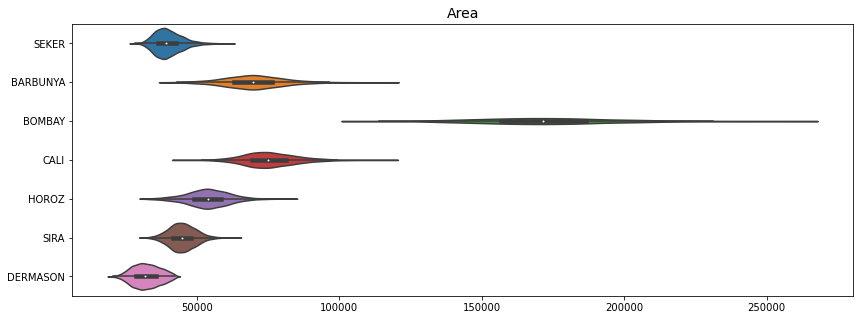

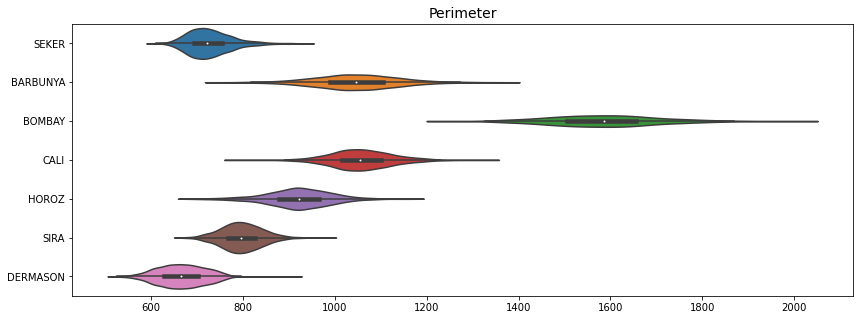

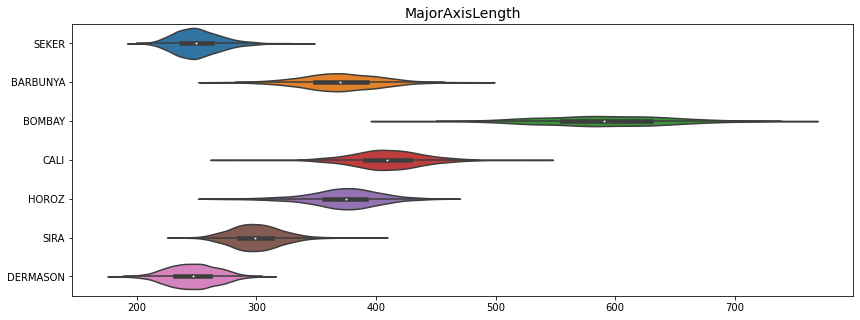

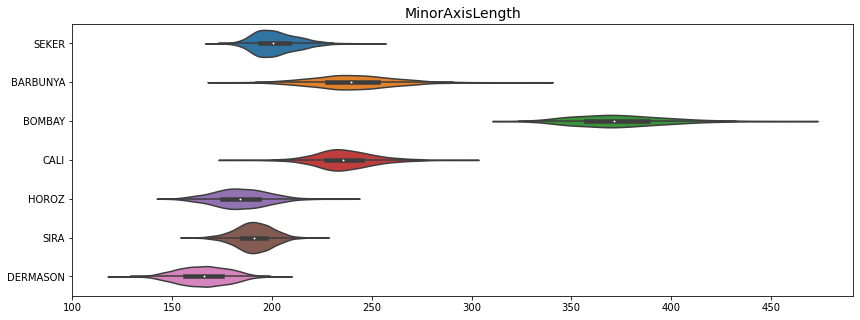

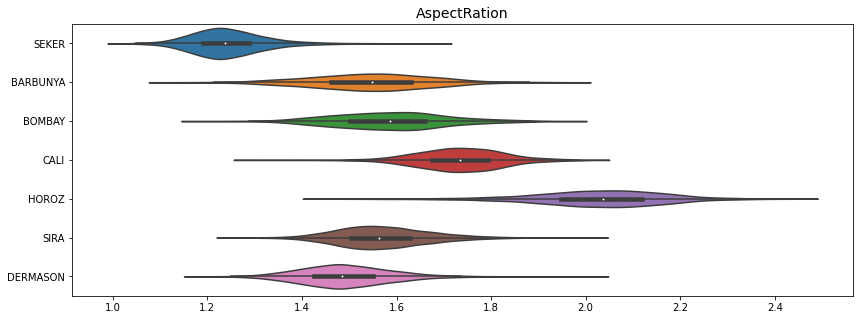

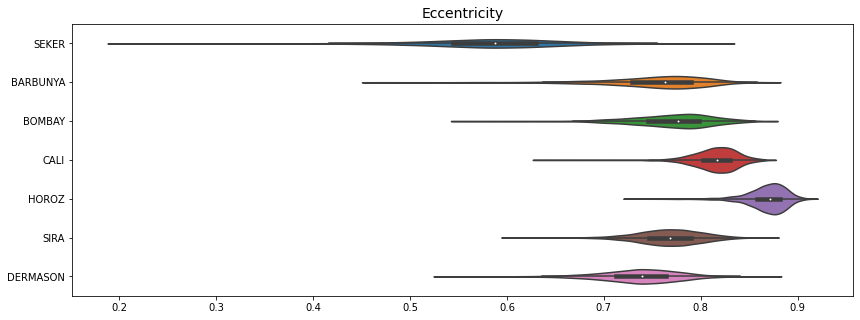

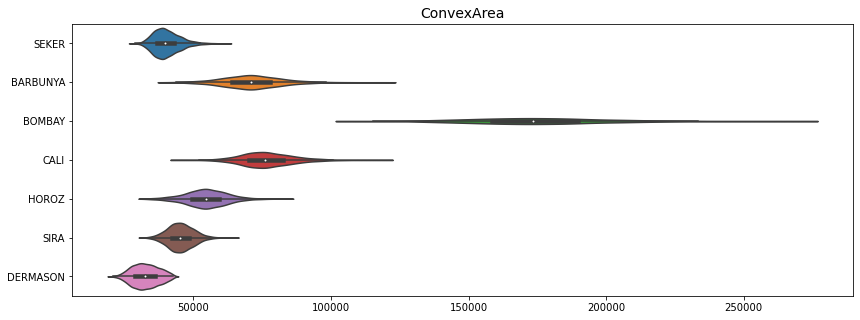

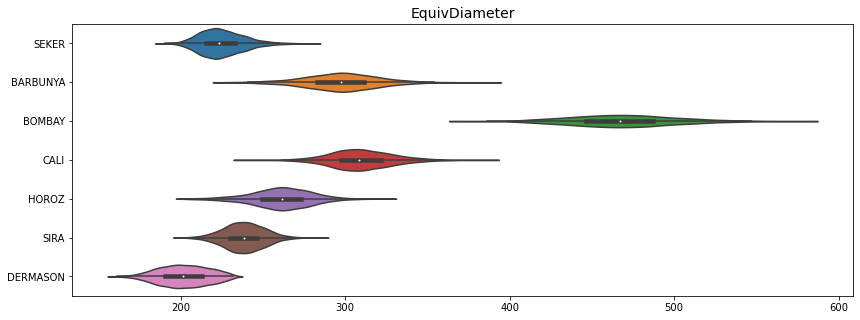

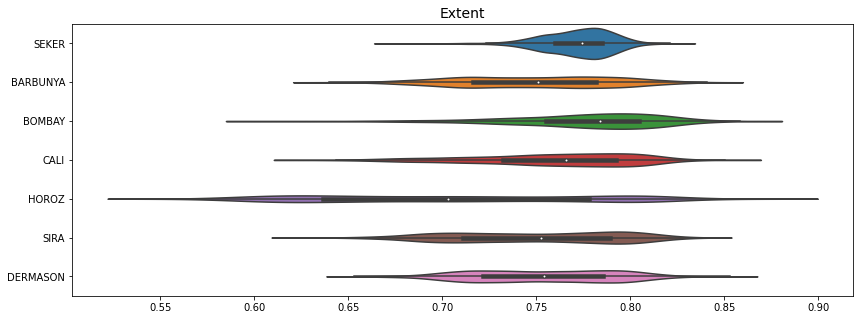

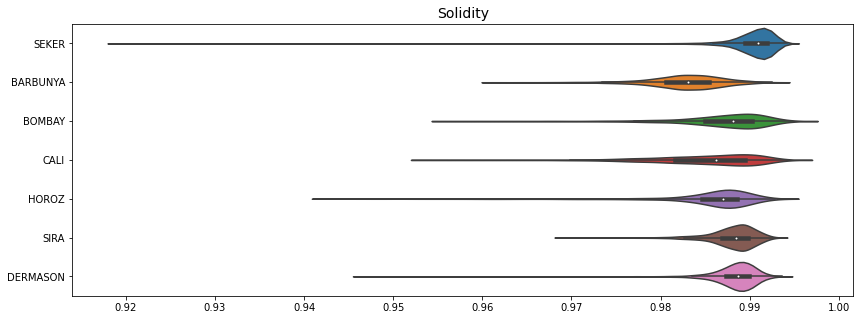

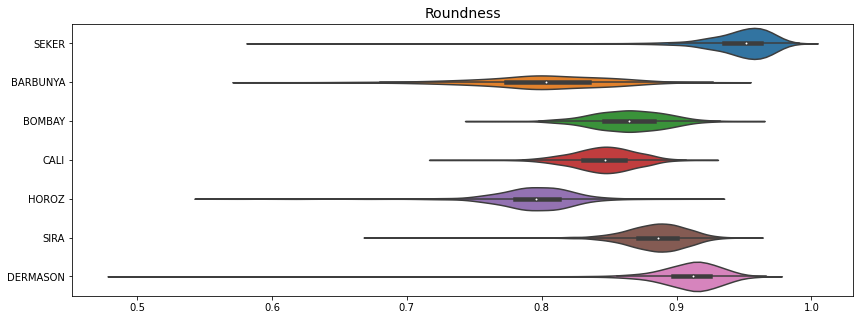

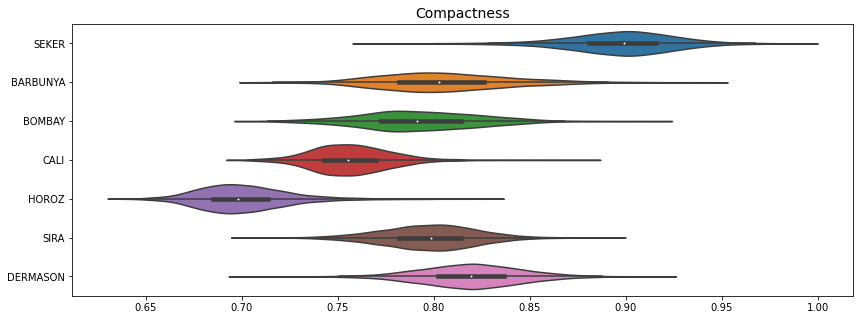

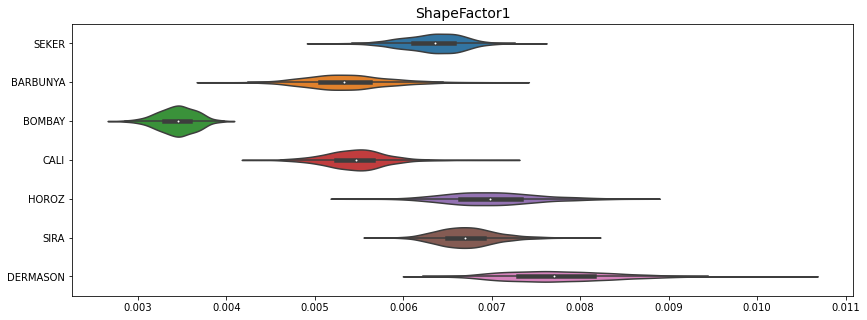

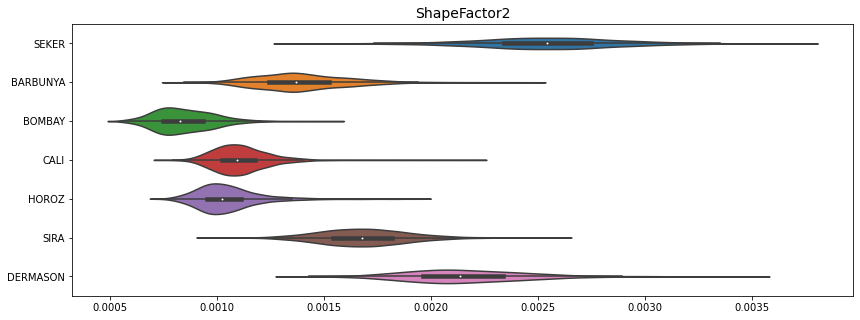

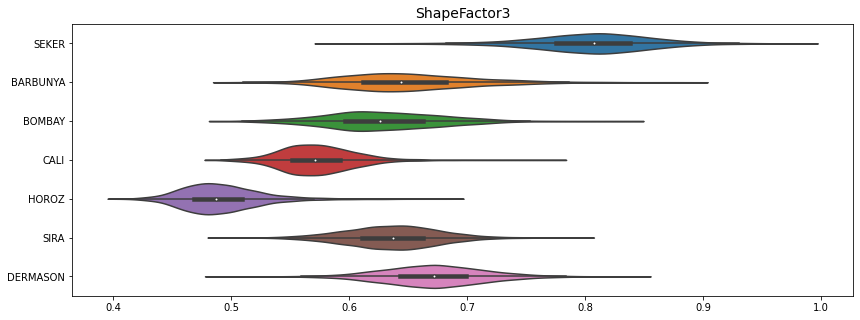

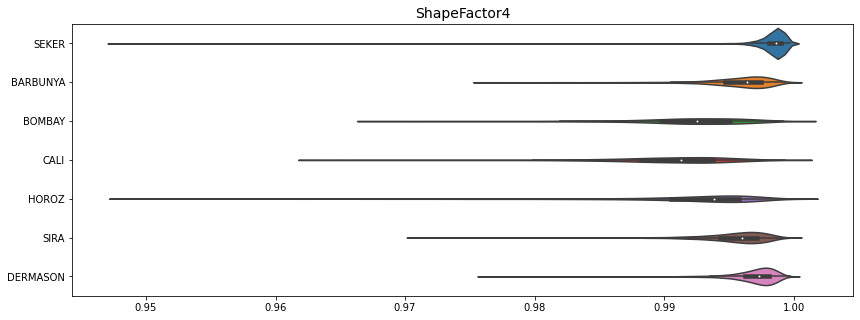

In [687]:
for column in df.columns[:-1]:
    plt.figure(figsize=(14,5))
    plt.title(column, fontdict={'size':14})
    sns.violinplot(data=df, x=column, y='Class')
    plt.xlabel('')
    plt.ylabel('')
    plt.show()

### In some metrics we observe a significant differentiation of the distribution and range between classes, especially in those closely related to the size of the seeds. It seems that the Bombay  are the largest and the Dermason are the smallest seeds.

In [688]:
means_by_class = df.groupby('Class').mean().sort_values('Area', ascending=True).T

In [689]:
means_by_class[:2].rename({'Area': 'Mean Area', 'Perimeter': 'Mean Perimeter'})

Class,DERMASON,SEKER,SIRA,HOROZ,BARBUNYA,CALI,BOMBAY
Mean Area,32118.710942,39881.299951,44729.128604,53671.732796,69804.133132,75538.211043,173485.059387
Mean Perimeter,665.209536,727.672440,796.418737,920.108600,1046.105764,1057.634282,1585.619079


### Plotting average Area and Perimeter for each class

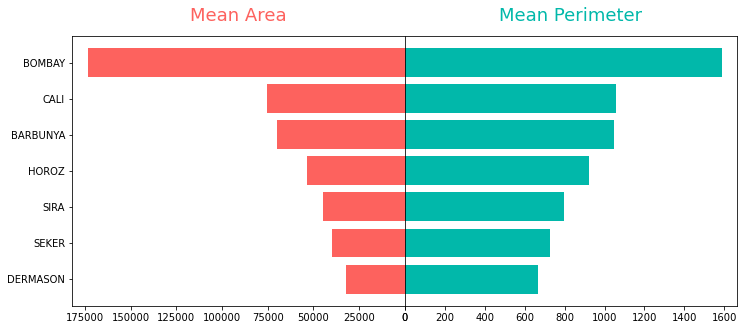

In [690]:
fig, axes = plt.subplots(figsize=(12,5), ncols=2, sharey=True)
fig.tight_layout()

axes[0].barh(means_by_class.columns, means_by_class.loc['Area'], align='center', color='#fd625e')
axes[0].set_title('Mean Area', fontsize=18, pad=15, color='#fd625e')

axes[1].barh(means_by_class.columns, means_by_class.loc['Perimeter'], align='center', color='#01b8aa')
axes[1].set_title('Mean Perimeter', fontsize=18, pad=15, color='#01b8aa')

axes[0].invert_xaxis() 
axes[1].tick_params(axis='y', colors='#fd625e')

plt.subplots_adjust(wspace=0, top=0.85, bottom=0.1, left=0.18, right=0.95)

In [691]:
means_by_class[2:4].rename({'MajorAxisLength': 'Mean MajorAxisLength', 'MinorAxisLength': 'MinorAxisLength'})

Class,DERMASON,SEKER,SIRA,HOROZ,BARBUNYA,CALI,BOMBAY
Mean MajorAxisLength,246.557279,251.291957,299.380258,372.693927,370.044279,409.499538,593.152075
MinorAxisLength,165.657143,201.909653,190.800250,184.197789,240.309352,236.370616,374.352547


### Plotting average MajorAxisLength and MinorAxisLength for each class

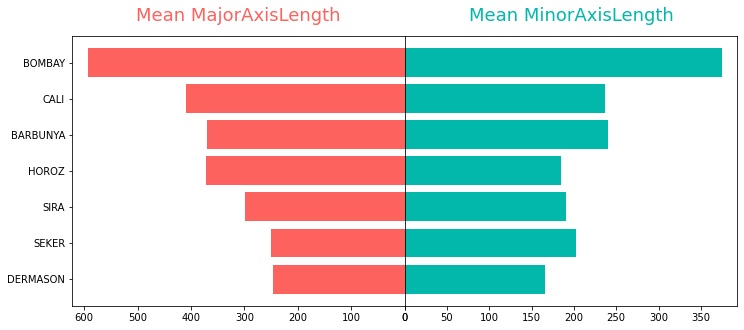

In [692]:
fig, axes = plt.subplots(figsize=(12,5), ncols=2, sharey=True)
fig.tight_layout()

axes[0].barh(means_by_class.columns, means_by_class.loc['MajorAxisLength'], align='center', color='#fd625e')
axes[0].set_title('Mean MajorAxisLength', fontsize=18, pad=15, color='#fd625e')

axes[1].barh(means_by_class.columns, means_by_class.loc['MinorAxisLength'], align='center', color='#01b8aa')
axes[1].set_title('Mean MinorAxisLength', fontsize=18, pad=15, color='#01b8aa')

axes[0].invert_xaxis()

axes[1].tick_params(axis='y', colors='#fd625e')

plt.subplots_adjust(wspace=0, top=0.85, bottom=0.1, left=0.18, right=0.95)

## Checking the number of entries for each class

In [693]:
df.Class.value_counts()

DERMASON    3546
SIRA        2636
SEKER       2027
HOROZ       1860
CALI        1630
BARBUNYA    1322
BOMBAY       522
Name: Class, dtype: int64

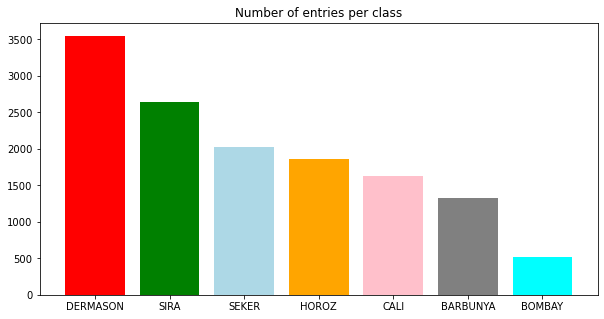

In [694]:
colors = ['red', 'green', 'lightblue', 'orange', 'pink', 'gray', 'cyan']

plt.figure(figsize=(10,5))
plt.title("Number of entries per class")
plt.bar(x=df.Class.value_counts().index, height=df.Class.value_counts().values, color=colors)
plt.show()

### and percentage

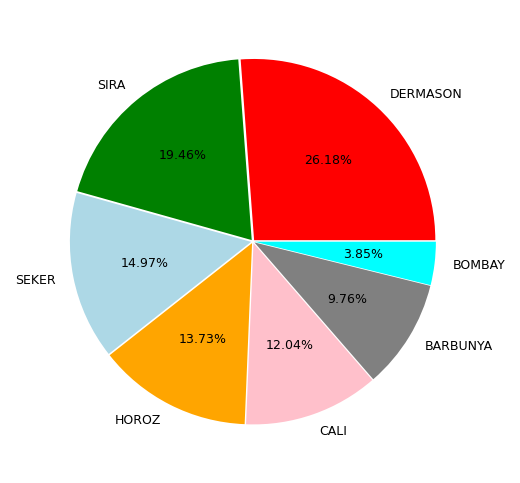

In [695]:
plt.figure(dpi=150)

plt.pie(x=df.Class.value_counts(), 
        labels=df.Class.value_counts().index, 
        autopct='%.2f%%', 
        explode=[0.01, 0.01, 0.01,0.01, 0.01, 0.01, 0.01],
        textprops={'fontsize': 6},
        colors=colors)

plt.show()

###  We can see our data set is highly unbalanced with only 3.85% of Bombay in total number of seeds comparing to the other varieties. That could be a problem, but on the other hand if we look on statistics Bombay seeds seem to be very different from the other so maybe our models can deal with it without our help.

## Time to build some simple model we can later reference to.
## Let's try with Decision Tree Classifier

### Dividing data for features and target

In [696]:
X, y = df[df.columns[:-1]], df['Class']

### Testing  Decision Tree on full data

In [697]:
tree = DecisionTreeClassifier()
tree.fit(X, y)
y_pred = tree.predict(X)
print(f'Accuracy : {accuracy_score(y_pred, y)}')
print(f'F1-score : {f1_score(y_pred, y, average="weighted")}')

Accuracy : 1.0
F1-score : 1.0


### Cross Validation

#### Since the data is sorted by class we need to use StratifiedKFold to obtain reasonable results

In [698]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=13)

### Let's check mean accuracy and f1-score for ten random splits of data.

In [699]:
%%time
print(f"Mean accuracy:  {cross_val_score(tree, X, y, cv=skf, scoring='accuracy').mean()}")

Mean accuracy:  0.8968479345059329
Wall time: 2.33 s


In [700]:
%%time
print(f"Mean f1-score:  {cross_val_score(tree, X, y, cv=skf, scoring='f1_macro').mean()}")

Mean f1-score:  0.9125374962103505
Wall time: 2.43 s


### Not bad and very fast.

### Dividing data for trainig and testing datasets

#### At first let's add new numeric column with classes for XGBoost algorithm.

In [701]:
classes_dict = dict(zip([0, 1, 2, 3, 4, 5, 6], ['BARBUNYA', 'BOMBAY', 'CALI', 'DERMASON', 'HOROZ', 'SEKER', 'SIRA']))

In [702]:
df['Class_Num'] = df['Class'].replace(classes_dict.values(), classes_dict.keys())

#### ...and now let's use it as our target.

In [703]:
y = df['Class_Num']

#### First split

In [704]:
X_train, X_test_temp, y_train, y_test_temp = train_test_split(X, y, test_size=0.3, stratify=y, shuffle=True, random_state=42)

#### Splitting test data to get part for final validation only

In [705]:
X_test, X_val, y_test, y_val = train_test_split(X_test_temp, y_test_temp, test_size=0.5, stratify=y_temp, shuffle=True, random_state=17)

#### Checking shapes

In [706]:
print(X_train.shape, X_test.shape, X_val.shape)
print(y_train.shape, y_test.shape, y_val.shape)

(9480, 16) (2031, 16) (2032, 16)
(9480,) (2031,) (2032,)


### Testing DecisionTreeClassifier on splitted data

In [707]:
%%time
tree2 = DecisionTreeClassifier()
tree2.fit(X_train, y_train)
y_pred = tree2.predict(X_val)
print(f'Accuracy : {accuracy_score(y_pred, y_val)}')
print(f'F1-score : {f1_score(y_pred, y_val, average="weighted")}')

Accuracy : 0.8932086614173228
F1-score : 0.8935589734792723
Wall time: 171 ms


In [708]:
f1_per_class = pd.DataFrame(
        {
        'Class': [classes_dict[num] for num in y_train.unique()], 
        'f1-score': f1_score(y_pred, y_val, labels=y_train.unique(), average=None)
    }
)

f1_per_class.set_index('Class').sort_values('f1-score', ascending=False)

,f1-score
Class,
BOMBAY,1.000000
SEKER,0.937198
HOROZ,0.926391
CALI,0.907631
DERMASON,0.887630
BARBUNYA,0.887179
SIRA,0.814815


In [709]:
print(classification_report(y_pred, y_val, labels=y_train.unique()))

              precision    recall  f1-score   support

           6       0.81      0.82      0.81       387
           4       0.92      0.93      0.93       278
           3       0.88      0.89      0.89       527
           1       1.00      1.00      1.00        78
           0       0.87      0.90      0.89       192
           5       0.96      0.92      0.94       317
           2       0.92      0.89      0.91       253

    accuracy                           0.89      2032
   macro avg       0.91      0.91      0.91      2032
weighted avg       0.89      0.89      0.89      2032



### In general, the Decision Tree Classifier works quite well and, as we assumed, there was no problem with recognizing the Bombay seeds. 
### Most mistakes were made in the Sira class.

### Confusion Matrix

In [710]:
conf_matrix = pd.DataFrame(confusion_matrix(y_val, y_pred, labels=y_train.unique()), 
                           columns=[classes_dict[num] for num in y_train.unique()])
conf_matrix.index = conf_matrix.columns
conf_matrix

,SIRA,HOROZ,DERMASON,BOMBAY,BARBUNYA,SEKER,CALI
SIRA,319,11,47,0,4,13,2
HOROZ,6,258,2,0,2,0,11
DERMASON,54,0,470,0,0,8,0
BOMBAY,0,0,0,78,0,0,0
BARBUNYA,4,3,0,0,173,4,14
SEKER,4,0,8,0,1,291,0
CALI,0,6,0,0,12,1,226


<Figure size 576x576 with 0 Axes>

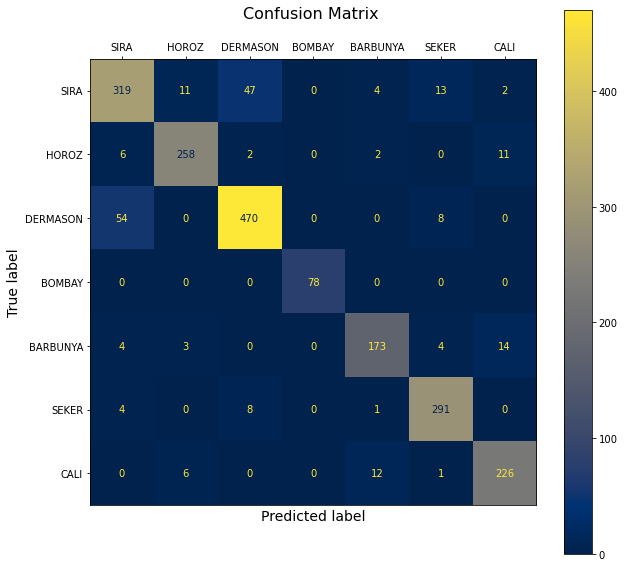

In [711]:
plt.figure(figsize=(8,8))

disp = ConfusionMatrixDisplay(confusion_matrix(y_val, y_pred, labels=y_train.unique()))
disp.plot(cmap='cividis')

ax = plt.gca()

ax.set_xticklabels([classes_dict[num] for num in y_train.unique()])
ax.set_yticklabels([classes_dict[num] for num in y_train.unique()])
ax.xaxis.tick_top()

ax.set_ylabel(ylabel='True label',fontdict={'size': 14})
ax.set_xlabel(xlabel='Predicted label',fontdict={'size': 14})

fig = disp.ax_.get_figure() 
fig.set_figwidth(10)
fig.set_figheight(10) 
plt.title('Confusion Matrix \n', fontdict={'size': 16})
plt.show()

### Now let's take a look at our heroes and find out why so many mistakes were made between Sira and Dermason...

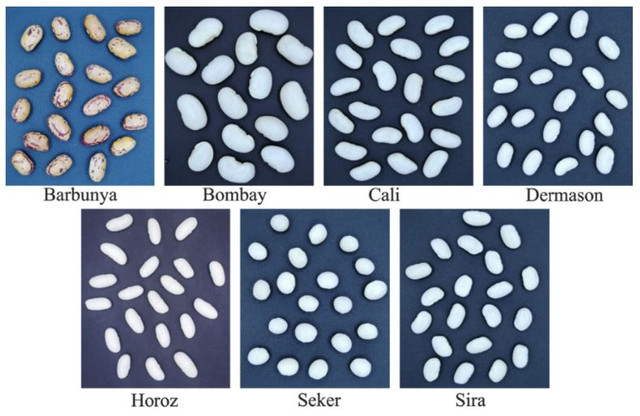

In [712]:
Image(filename='data/beans.jpg')

### - even for human eyes these two look almost the same.

### We also see that the Barbunya seeds have a different color and we can easily distinguish them from the others, but we have no color information in the data. They appear to be similar to Cali for our algorithm.

### Previously, we assumed that there could be multiple correlations between features. Let's find out now.

In [713]:
X.corr().round(2)

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,Roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4
Area,1.00,0.97,0.93,0.95,0.24,0.27,1.00,0.98,0.05,-0.20,-0.36,-0.27,-0.85,-0.64,-0.27,-0.36
Perimeter,0.97,1.00,0.98,0.91,0.39,0.39,0.97,0.99,-0.02,-0.30,-0.55,-0.41,-0.87,-0.77,-0.41,-0.43
MajorAxisLength,0.93,0.98,1.00,0.83,0.55,0.54,0.93,0.96,-0.08,-0.28,-0.60,-0.57,-0.78,-0.86,-0.57,-0.48
MinorAxisLength,0.95,0.91,0.83,1.00,-0.01,0.02,0.95,0.95,0.15,-0.16,-0.21,-0.02,-0.95,-0.48,-0.02,-0.27
AspectRation,0.24,0.39,0.55,-0.01,1.00,0.92,0.25,0.31,-0.37,-0.27,-0.76,-0.99,0.02,-0.84,-0.98,-0.45
Eccentricity,0.27,0.39,0.54,0.02,0.92,1.00,0.27,0.32,-0.32,-0.30,-0.72,-0.97,0.02,-0.86,-0.98,-0.45
ConvexArea,1.00,0.97,0.93,0.95,0.25,0.27,1.00,0.99,0.05,-0.21,-0.36,-0.27,-0.85,-0.64,-0.28,-0.36
EquivDiameter,0.98,0.99,0.96,0.95,0.31,0.32,0.99,1.00,0.03,-0.23,-0.44,-0.33,-0.89,-0.71,-0.33,-0.39
Extent,0.05,-0.02,-0.08,0.15,-0.37,-0.32,0.05,0.03,1.00,0.19,0.34,0.35,-0.14,0.24,0.35,0.15
Solidity,-0.20,-0.30,-0.28,-0.16,-0.27,-0.30,-0.21,-0.23,0.19,1.00,0.61,0.30,0.15,0.34,0.31,0.70


### ... in fact it is. Then maybe we do not need 16 features and we can reduce their count. We may appreciate it later in the training stage of many algorithms. Let's try to minimize number of dimensions of our data.

### Scaling the data

In [714]:
scaler = StandardScaler()

X_train_sc = scaler.fit_transform(X_train)
X_val_sc, X_test_sc = scaler.transform(X_val), scaler.transform(X_test)

### Principal Component Analysis

In [715]:
pca = PCA()

X_train_pca = pca.fit_transform(X_train_sc)
X_val_pca, X_test_pca = pca.transform(X_val_sc), pca.transform(X_test_sc)

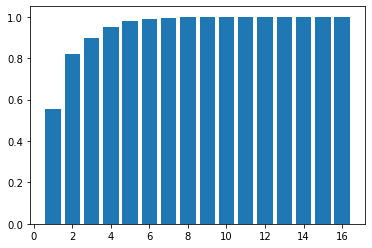

In [716]:
plt.bar(range(1, pca.n_components_ + 1), np.cumsum(pca.explained_variance_ratio_ ))
plt.show()

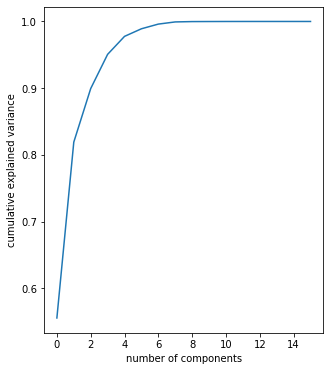

In [717]:
plt.figure(figsize=(5,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [718]:
pca_test = PCA(svd_solver='full', n_components=0.99)
principal_components = pca_test.fit_transform(X_train_sc)
principal_df = pd.DataFrame(data=principal_components)
principal_df.head()

,0,1,2,3,4,5,6
0,-0.868920,0.223973,-0.160660,-0.674071,-0.288278,-0.306104,-0.235993
1,2.570076,-2.128582,-0.862373,1.116887,-0.016431,-0.391180,0.449267
2,-2.184377,-1.754457,-0.731249,-0.797133,-0.270677,0.584902,-0.186771
3,8.300144,5.210383,-0.732750,-0.222150,-0.569225,0.961882,0.427180
4,-2.577989,-1.018857,-0.529575,-0.655348,-0.383649,0.415877,-0.133921


### As we can see, 7 principal components are enough to explain more than 99% of the variance and get good results. 
### On the other hand, looking at the previous charts, 6 should also be enough.

### Now let's compare the metrics and training time for original data and PCA-transformed data for 4, 5, 6 and 7 components.


In [719]:
results_df = pd.DataFrame(
    index=["Accuracy", "Mean F1-score", "Total time"], 
    columns=["X", "X_pca(7)", "X_pca(6)", "X_pca(5)", "X_pca(4)"]
    )

In [720]:
components_nums = [16, 7, 6, 5, 4]

In [721]:
for num, name in zip(components_nums, results_df.columns):
    
    start = datetime.now()
    
    tree_model_pca = DecisionTreeClassifier()
    tree_model_pca.fit(X_train_pca[:, :num], y_train)
    y_pred = tree_model_pca.predict(X_val_pca[:, :num])
 
    finish = datetime.now()
    
    results_df[name] = [round(accuracy_score(y_pred, y_val), 3), round(f1_score(y_pred, y_val, average="weighted"), 3), finish - start]

In [722]:
results_df

,X,X_pca(7),X_pca(6),X_pca(5),X_pca(4)
Accuracy,0.886,0.894,0.895,0.89,0.842
Mean F1-score,0.886,0.894,0.895,0.89,0.841
Total time,0:00:00.163847,0:00:00.071268,0:00:00.063879,0:00:00.050172,0:00:00.046953


### The use of 6 principal components significantly shortens the time and allows to obtain similar (even better ) results compared to the use of full data.

In [723]:
pc_num = 6

In [724]:
X_train_pca, X_val_pca, X_test_pca = X_train_pca[:,:pc_num], X_val_pca[:,:pc_num], X_test_pca[:,:pc_num]

In [725]:
tree_pca = DecisionTreeClassifier()
tree_pca.fit(X_train_pca, y_train)
y_pred = tree_pca.predict(X_val_pca)
print(f'Accuracy : {accuracy_score(y_pred, y_val)}')
print(f'F1-score : {f1_score(y_pred, y_val, average="weighted")}')

Accuracy : 0.8932086614173228
F1-score : 0.8931346621029521


### Looking good.

### Now it's time to try other algorithms and make a comparison.

In [726]:
def compare(training_x, training_y):
    
    algorithms = [
        DecisionTreeClassifier(),
        LinearSVC(max_iter=10000), 
        LogisticRegression(max_iter=10000), 
        RandomForestClassifier(), 
        XGBClassifier()
        ]

    comparison_df = pd.DataFrame(
        columns=['DecisionTreeClassifier', 'LinearSVC', 'LogisticRegression', 'RandomForestClassifier', 'XGBClassifier'],
        index=['Accuracy', 'Mean F1-score', 'Total time']
        )

    for model, name in zip(algorithms, comparison_df.columns):

        start = datetime.now()

        model.fit(training_x, training_y)
        y_pred = model.predict(X_val_pca)

        finish = datetime.now()

        comparison_df[name] = [round(accuracy_score(y_pred, y_val), 4), 
                               round(f1_score(y_pred, y_val, average="weighted"), 4), 
                               (finish - start)]
    
    return comparison_df

In [727]:
%%time
comp1 = compare(X_train_pca, y_train)
comp1

Wall time: 7.22 s


,DecisionTreeClassifier,LinearSVC,LogisticRegression,RandomForestClassifier,XGBClassifier
Accuracy,0.8917,0.8952,0.9188,0.9193,0.9222
Mean F1-score,0.8918,0.8972,0.9187,0.9193,0.9223
Total time,0:00:00.060540,0:00:02.325630,0:00:00.311990,0:00:02.164720,0:00:02.349247


### Looking at it, we see that LogisticRegression gives us good results in a very short time. The best were XGB and Random Forest. We must remember that this comparison was made on highly unbalanced data without optimizing our models. Now let's try to balance the data and compare the results.

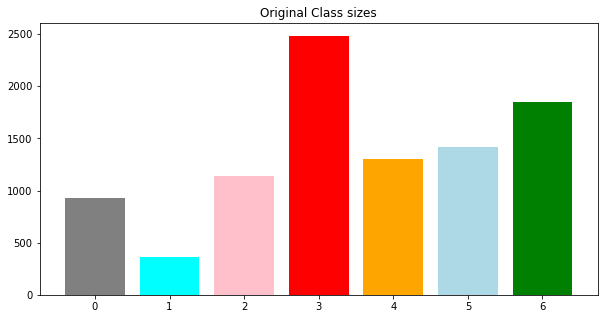

In [728]:
plt.figure(figsize=(10,5))
plt.title("Original Class sizes")
plt.bar(x=y_train.value_counts().index, height=y_train.value_counts().values, color=colors)
plt.show()

### At first let's try Synthetic Minority Over-sampling Technique

In [729]:
sm = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)
Xsm_train, ysm_train = sm.fit_resample(X_train_pca, y_train)

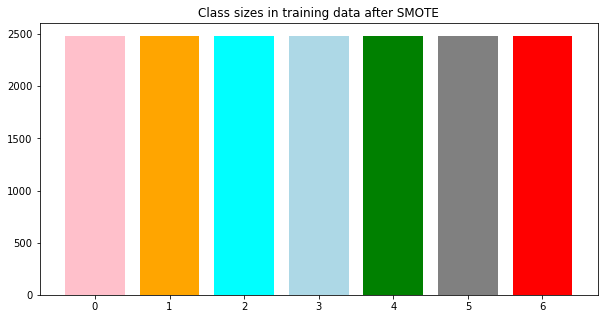

In [730]:
plt.figure(figsize=(10,5))
plt.bar(ysm_train.value_counts().index, ysm_train.value_counts().values, color=colors)
plt.title('Class sizes in training data after SMOTE')
plt.show()

#### Results after resampling with SMOTE:

In [731]:
%%time
comp2= compare(Xsm_train, ysm_train)
comp2

Wall time: 16.4 s


,DecisionTreeClassifier,LinearSVC,LogisticRegression,RandomForestClassifier,XGBClassifier
Accuracy,0.8873,0.8858,0.9139,0.9193,0.9168
Mean F1-score,0.8876,0.8886,0.9137,0.9193,0.9168
Total time,0:00:00.126925,0:00:03.707310,0:00:00.659616,0:00:03.824576,0:00:08.016241


#### Random undersampling

In [732]:
undersampler = RandomUnderSampler(sampling_strategy='auto')
X_und, y_und = undersampler.fit_resample(X_train_pca, y_train)

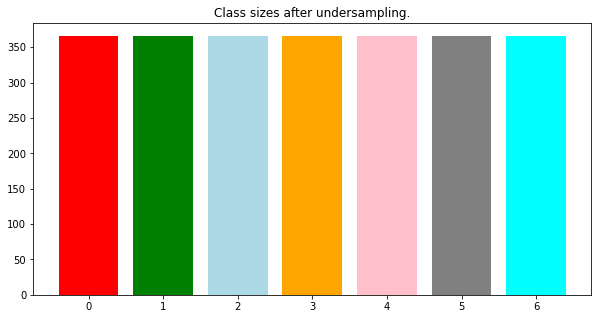

In [733]:
plt.figure(figsize=(10,5))
plt.bar(y_und.value_counts().index, y_und.value_counts().values, color=colors)
plt.title('Class sizes after undersampling.')
plt.show()

In [734]:
comp3 = compare(X_und, y_und)

#### Results with original data

In [735]:
comp1

,DecisionTreeClassifier,LinearSVC,LogisticRegression,RandomForestClassifier,XGBClassifier
Accuracy,0.8917,0.8952,0.9188,0.9193,0.9222
Mean F1-score,0.8918,0.8972,0.9187,0.9193,0.9223
Total time,0:00:00.060540,0:00:02.325630,0:00:00.311990,0:00:02.164720,0:00:02.349247


#### Results after using SMOTE

In [736]:
comp2

,DecisionTreeClassifier,LinearSVC,LogisticRegression,RandomForestClassifier,XGBClassifier
Accuracy,0.8873,0.8858,0.9139,0.9193,0.9168
Mean F1-score,0.8876,0.8886,0.9137,0.9193,0.9168
Total time,0:00:00.126925,0:00:03.707310,0:00:00.659616,0:00:03.824576,0:00:08.016241


#### Results after random undersampling

In [737]:
comp3

,DecisionTreeClassifier,LinearSVC,LogisticRegression,RandomForestClassifier,XGBClassifier
Accuracy,0.8824,0.8848,0.9168,0.9173,0.9065
Mean F1-score,0.8823,0.8877,0.9166,0.9172,0.9065
Total time,0:00:00.027137,0:00:00.488656,0:00:00.058596,0:00:00.616481,0:00:00.761411


### Now we can see that rebalancing the data has no positive effect on the final results. To be sure, let's compare the performance of LinearSVC with changed class weights with the same model without modified weights.


In [738]:
class_weights = dict(zip(np.unique(y_train), compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train))) 

In [739]:
class_weights

{0: 1.4640926640926641,
 1: 3.700234192037471,
 2: 1.186928759233755,
 3: 0.5456429147001266,
 4: 1.0401579986833442,
 5: 0.9543944427665358,
 6: 0.7340301974448316}

### LinearSVC

In [740]:
model_svc = LinearSVC(max_iter=10000)
model_svc.fit(X_train_pca, y_train)
y_pred = model_svc.predict(X_val_pca)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       198
           1       1.00      1.00      1.00        78
           2       0.91      0.91      0.91       245
           3       0.86      0.94      0.90       532
           4       0.89      0.96      0.93       279
           5       0.90      0.93      0.92       304
           6       0.90      0.72      0.80       396

    accuracy                           0.90      2032
   macro avg       0.91      0.91      0.91      2032
weighted avg       0.90      0.90      0.89      2032



### LinearSVC with modified weights

In [741]:
model_w = LinearSVC(max_iter=10000, class_weight=class_weights)
model_w.fit(X_train_pca, y_train)
y_pred = model_w.predict(X_val_pca)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.90      0.90       198
           1       1.00      1.00      1.00        78
           2       0.88      0.91      0.90       245
           3       0.88      0.93      0.90       532
           4       0.88      0.96      0.92       279
           5       0.87      0.94      0.91       304
           6       0.89      0.70      0.78       396

    accuracy                           0.89      2032
   macro avg       0.90      0.90      0.90      2032
weighted avg       0.89      0.89      0.88      2032



### Again no improvement

### For further analysis, let's stick with the six principal components obtained with PCA() from data scaled by StandardScaler() and focus on the 3 algorithms that worked best, namely: LogisticRegression, RandomForestClassifier, XGBClassifier.

### Preparing Stratified K-Folds cross-validator

In [742]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)

## Hyperparameter optimization

### 1. Logistic Regression

#### Finding best parameters by using GridSearchSV

In [743]:
param_grid = {"penalty":["l1","l2"],
              "C":[1000,100,10,1,0.1,0.01]}

gs = GridSearchCV(LogisticRegression(max_iter=10000, solver='saga'), param_grid, cv=skf, scoring='f1_micro')

In [744]:
%%time
gs.fit(X_train_pca, y_train)

Wall time: 4min 25s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=13, shuffle=True),
             estimator=LogisticRegression(max_iter=10000, solver='saga'),
             param_grid={'C': [1000, 100, 10, 1, 0.1, 0.01],
                         'penalty': ['l1', 'l2']},
             scoring='f1_micro')

In [745]:
gs.best_params_

{'C': 1, 'penalty': 'l1'}

#### Fitting Log_Reg model with best parameters and making prediction on validation data

In [746]:
%%time
log_reg = LogisticRegression(C=1, penalty='l1', max_iter=10000, solver='saga')
log_reg.fit(X_train_pca, y_train)
y_pred = log_reg.predict(X_val_pca)

Wall time: 10.3 s


#### Results for the best Log_Reg model found


In [747]:
f1_score(y_pred, y_val, average='weighted')

0.9197586388068613

In [748]:
print(classification_report(y_pred, y_val))

              precision    recall  f1-score   support

           0       0.90      0.95      0.93       189
           1       1.00      1.00      1.00        78
           2       0.95      0.93      0.94       249
           3       0.91      0.93      0.92       519
           4       0.96      0.94      0.95       285
           5       0.94      0.93      0.93       309
           6       0.87      0.86      0.86       403

    accuracy                           0.92      2032
   macro avg       0.93      0.93      0.93      2032
weighted avg       0.92      0.92      0.92      2032



### 2. Random Forest Classifier

#### Finding best parameters by using RandomizedSearchSV

In [749]:
param_grid2 = {"min_samples_leaf": [1,5,10,25],
               "min_samples_split": [2,4,10,20],
               "max_depth": [2, 5, 8, 10, 20, 40],
               "n_estimators": [25, 50, 100, 150, 200, 250, 300]}

rs = RandomizedSearchCV(RandomForestClassifier(), param_grid2, cv=skf, scoring='f1_micro', n_jobs=-1, verbose=1, random_state=42, n_iter=100)

In [750]:
%%time
rs.fit(X_train_pca, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Wall time: 7min 4s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=13, shuffle=True),
                   estimator=RandomForestClassifier(), n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [2, 5, 8, 10, 20, 40],
                                        'min_samples_leaf': [1, 5, 10, 25],
                                        'min_samples_split': [2, 4, 10, 20],
                                        'n_estimators': [25, 50, 100, 150, 200,
                                                         250, 300]},
                   random_state=42, scoring='f1_micro', verbose=1)

In [751]:
rs.best_params_

{'n_estimators': 250,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_depth': 40}

#### Fitting Random Forest model with best parameters and making prediction on test data

In [752]:
%%time
random_forest = RandomForestClassifier(**rs.best_params_)
random_forest.fit(X_train_pca, y_train)
y_pred2 = random_forest.predict(X_val_pca)

Wall time: 6.1 s


#### Results for the best Random Forest model found

In [753]:
f1_score(y_pred2, y_val, average='weighted')

0.9242643044949671

In [754]:
print(classification_report(y_pred2, y_val))

              precision    recall  f1-score   support

           0       0.90      0.95      0.93       189
           1       1.00      1.00      1.00        78
           2       0.95      0.93      0.94       251
           3       0.92      0.92      0.92       529
           4       0.95      0.94      0.94       284
           5       0.94      0.94      0.94       305
           6       0.88      0.88      0.88       396

    accuracy                           0.92      2032
   macro avg       0.93      0.94      0.94      2032
weighted avg       0.92      0.92      0.92      2032



### 3. XGBClassifier

#### Finding best parameters by using RandomizedSearchSV

In [755]:
param_grid3 = {
         'n_estimators': [50, 100, 150],
         'learning_rate': uniform(loc=0.1, scale=0.5),
         'max_depth': [5, 6, 7],
         'gamma': uniform(loc=0.05, scale=2),
         'reg_lambda': uniform(loc=0.05, scale=2),
         'min_child_weight': [10, 50],
         'subsample': [0.25, 0.5, 0.75, 1],
         'colsample_bynode': [0.1, 0.25, 0.5, 1]
     }

rs2 = RandomizedSearchCV(XGBClassifier(), param_grid3, cv=skf, scoring='f1_micro', n_jobs=-1, n_iter=100, random_state=42, verbose=1)

In [756]:
%%time
rs2.fit(X_train_pca, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Wall time: 5min 7s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=13, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importan...
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001C5EAB00370>,
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001C5EAB1EBE0>,
                                        'max_depth': [5, 6, 7],
                                        'min_child_weight': [10, 50],
                                        'n_estimators': [50, 100, 150],
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001C5EAB1E1F0>,
                                        'subsample': [0.25, 0.5, 0.75, 1]},
                   random_state=42, scoring='f1_micro', verbose=1)

In [757]:
rs2.best_params_

{'colsample_bynode': 0.25,
 'gamma': 1.0431223813661554,
 'learning_rate': 0.29480904310960176,
 'max_depth': 5,
 'min_child_weight': 10,
 'n_estimators': 150,
 'reg_lambda': 0.8284033574683263,
 'subsample': 1}

#### Fitting XGBClassifier model with best parameters and making prediction on test data

In [758]:
%%time
xgb = XGBClassifier(**rs2.best_params_)
xgb.fit(X_train_pca, y_train)
y_pred3 = xgb.predict(X_val_pca)

Wall time: 3.9 s


#### Results for the best Random Forest model found

In [759]:
f1_score(y_pred3, y_val, average='weighted')

0.9217068642755399

In [760]:
print(classification_report(y_pred3, y_val))

              precision    recall  f1-score   support

           0       0.91      0.94      0.92       192
           1       1.00      1.00      1.00        78
           2       0.94      0.93      0.94       246
           3       0.91      0.93      0.92       522
           4       0.96      0.94      0.95       285
           5       0.94      0.94      0.94       305
           6       0.88      0.86      0.87       404

    accuracy                           0.92      2032
   macro avg       0.93      0.93      0.93      2032
weighted avg       0.92      0.92      0.92      2032



## Final results on Test Data Set

In [602]:
y_test.shape

(2031,)

In [761]:
tuned_models = [log_reg, random_forest, xgb]

In [762]:
final_test_df = pd.DataFrame(index=['Accuracy', 'f1-score'])
predictions = {}

for model in tuned_models:
    
    predicted = model.predict(X_test_pca)
    
    final_test_df[str(model).split('(')[0]] = [accuracy_score(predicted, y_test), 
                                                     f1_score(predicted, y_test, average='weighted')] 
    
    predictions[str(model).split('(')[0]] = predicted

final_test_df

,LogisticRegression,RandomForestClassifier,XGBClassifier
Accuracy,0.920729,0.914820,0.914820
f1-score,0.920592,0.914816,0.914654


### Very similar results but Logistic Regression did the best job.

LogisticRegression


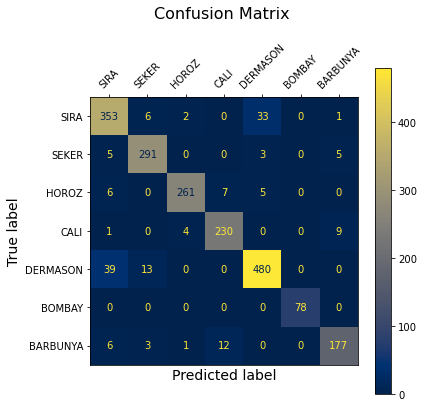

RandomForestClassifier


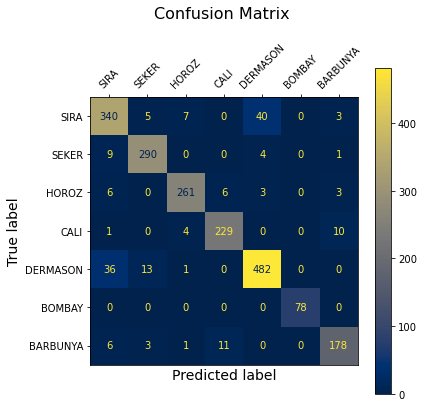

XGBClassifier


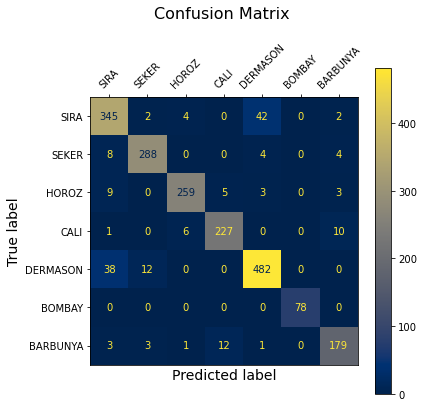

In [767]:
for name, prediction in predictions.items():
    print(name)
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test, prediction, labels=y_test.unique()))
    disp.plot(cmap='cividis')

    ax = plt.gca()

    ax.set_xticklabels([classes_dict[num] for num in y_test.unique()], rotation = 45)
    ax.set_yticklabels([classes_dict[num] for num in y_test.unique()])
    ax.xaxis.tick_top()

    ax.set_ylabel(ylabel='True label',fontdict={'size': 14})
    ax.set_xlabel(xlabel='Predicted label',fontdict={'size': 14})

    fig = disp.ax_.get_figure() 
    fig.set_figwidth(6)
    fig.set_figheight(6) 
    plt.title('Confusion Matrix \n', fontdict={'size': 16})
    plt.show()

# ________

## Testing tuned models (cross validation)

In [768]:
def test_tuned(X, y, tuned_models, folds_num=5):
    
    tuned_results = pd.DataFrame(index=['Mean Accuracy', 'Mean f1-score', 'Total Time (sec)'])
    scoring = {'acc': 'accuracy','f1_macro': 'f1_macro'}
    cv = StratifiedKFold(shuffle=True, n_splits=folds_num)  
    
    for tuned_model in tuned_models:
        
        pipeline = Pipeline([("scaler", StandardScaler()),
                             ("pca", PCA(n_components=pc_num)),
                             ("model", tuned_model)
                            ])

        scores = cross_validate(pipeline, X, y, cv=cv, scoring=scoring)
        
        tuned_results[str(tuned_model).split('(')[0]] = [scores['test_acc'].mean(), 
                                                         scores['test_f1_macro'].mean(), 
                                                         scores['fit_time'].sum()]

    return round(tuned_results, 3)

In [823]:
%%time
test_tuned(X, y, tuned_models)

Wall time: 1min 33s


,LogisticRegression,RandomForestClassifier,XGBClassifier
Mean Accuracy,0.924,0.927,0.925
Mean f1-score,0.935,0.938,0.936
Total Time (sec),45.830,32.972,13.686


### Conclusions:

#### Cross-validation shows that XGBClassifier is the fastest and is appropriate for these data but all of tested estimators has       comparable performance.
        
#### Important fact is that overall accuracy and f1-score at levels about 91-93% are pretty good results. There is still place for some improvement, probably mostly on stage of data preparation like for example removing outliers.
        
#### The worst results are observed in classes 6 and 3 which are Sira and Dermason. They are very similar for humans and for algorithms. On the other hand, there are some significant differences between them when it comes to the distribution of some features, especially those related to grain size. Maybe this could be a key to building better models.

### ______

#### Important fact is that overall accuracy and f1-score at levels about 91-93% are pretty good results. There is still place for some improvement, probably mostly on stage of data preparation like for example removing outliers.

#### The worst results are observed in classes 6 and 3 which are Sira and Dermason. They are very similar for humans and for algorithms. On the other hand, there are some significant differences between them when it comes to the distribution of some features, especially those related to grain size. Maybe this could be a key to building better models.
### __________________________________________________________

### Time to prepare final and ready to use pipeline with trained and tuned model. I'll choose XGBClassifier for this task.

### Saving final XGB model

In [786]:
final_model = xgb
final_pipe = Pipeline([("scaler", StandardScaler()),
                       ("pca", PCA(n_components=pc_num)),
                       ("model", final_model)
                      ])
final_pipe.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=6)),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=0.25,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=1.0431223813661554,
                               gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.29480904310960176, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=5,
                               max_leaves=None, min_child_weight=10,
                               missing=nan, monotone_constraints=None,
                               n_estimators=150, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', predictor=None, ...))])

In [787]:
joblib.dump(final_pipe, "dry_bean_xgb_pipe")

['dry_bean_xgb_pipe']

### Ready to use function:

In [813]:
def xgb_predict(data):
    estimator = joblib.load("dry_bean_xgb_pipe")
    predictions = estimator.predict(data)
    return predictions

### Testing 'xgb_predict' function

In [821]:
predictions = xgb_predict(X)
predictions

array([5, 5, 5, ..., 3, 6, 6], dtype=int64)

In [822]:
accuracy_score(predictions, y)

0.967953924536661